In [410]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
from scipy.optimize import curve_fit

main_folder = Path('.')

# Make an empty list to store dataframes
all_dataframes = []

# Loop through all subfolders within the main folder
for subfolder in main_folder.iterdir():
    if subfolder.is_dir():
        # Loop through all CSV files within the subfolder
        for csv_file in subfolder.glob('*.csv'):  # Find all CSV files in the folder
            try:
                # Load each CSV file into a pandas dataframe
                df = pd.read_csv(csv_file, encoding='ISO-8859-1', skiprows=7)
            except Exception as e:
                print(f"Error reading {csv_file}: {e}") # Skip to the next file if there's an error
                continue 

            # Add the folder/file name as columns to the dataframe for reference
            df['source_folder'] = subfolder.name
            # Add pretty name, replacing underscore with space
            df['source_folder_label'] = subfolder.name.replace('_', ' ')
            # Shorten csv file name to remove .csv suffix and RunX_ prefix
            df['source_file'] = csv_file.name[5:-4]
            # Add pretty name, replacing underscore with space
            df['source_file_label'] = csv_file.name[5:-4].replace('_', ' ')
            # Add linear Magnitude
            df['Linear Magnitude'] = 10**(df['Magnitude(dB)'] / 20.0)
            
            # Append the dataframe to the list
            all_dataframes.append(df)

# Concatenate all the dataframes into one dataframe
combined_df = pd.concat(all_dataframes, ignore_index=True)

print(combined_df)

      Sample  Frequency(Hz)  Magnitude(dB)    Phase(°)       source_folder  \
0          0        50000.0        20.3973    0.147448            AD4898-1   
1          1        51586.1        20.2129   -0.104204            AD4898-1   
2          2        53222.5        20.2494   -0.472960            AD4898-1   
3          3        54910.8        20.2185   -0.290529            AD4898-1   
4          4        56652.7        20.2598   -1.058680            AD4898-1   
...      ...            ...            ...         ...                 ...   
7595     195      2136190.0       -13.1795 -257.000000  UA741_5Gain_20Gain   
7596     196      2221850.0       -13.4842 -267.000000  UA741_5Gain_20Gain   
7597     197      2310950.0       -12.5978 -235.000000  UA741_5Gain_20Gain   
7598     198      2403620.0       -14.4037 -270.000000  UA741_5Gain_20Gain   
7599     199      2500000.0       -14.8161 -274.000000  UA741_5Gain_20Gain   

     source_folder_label        source_file  source_file_label 

In [411]:
# Function to filter out input spikes
def remove_input_spike(df, threshold=1.5):
    clean_df = df.copy()
    
    # Loop through the first 10 rows and compare the current Magnitude with the next
    for i in range(min(10, len(clean_df) - 1)):
        current_magnitude = clean_df['Magnitude(dB)'].iloc[i]
        next_magnitude = clean_df['Magnitude(dB)'].iloc[i + 1]
        
        if current_magnitude > next_magnitude * threshold:
            clean_df = clean_df.drop(clean_df.index[i])
    
    return clean_df

In [412]:
# Function to filter plot data by source_folder and source_file, and optionally filter out input spikes
def select_data(df, source_folder, source_file, raw):
    # Filter by folder and file
    plot_data_raw = df[(df['source_folder'] == source_folder) & (df['source_file'] == source_file)]
    
    # Default to plotting raw data
    if raw:
        return plot_data_raw
    
    # Filter out input spike
    return remove_input_spike(plot_data_raw)

In [413]:
#Function for finding -3dB
def find_cutoff(df, samples_to_average):
    avg_dc_gain = np.mean(df['Magnitude(dB)'][:samples_to_average])
    minus_three_dB_point = (avg_dc_gain - 3.0)

    min_distance_from_three_db = sys.float_info.max
    min_idx = samples_to_average
    for i in range(samples_to_average, len(df) - 1):
        magnitude = df['Magnitude(dB)'].iloc[i]
        distance_from_three_db = abs(magnitude - minus_three_dB_point)
        
        if distance_from_three_db < min_distance_from_three_db:
            min_distance_from_three_db = distance_from_three_db
            min_idx = i

    frequency = df['Frequency(Hz)'].iloc[min_idx]
    magnitude = df['Magnitude(dB)'].iloc[min_idx]
    #print(f'Mann low point idx<{min_idx}> dist from -3dB<{min_distance_from_three_db}> freq<{frequency}> mag dB<{magnitude}>')

    #idx = next(x for x, val in enumerate(df['Magnitude(dB)']) if val < (avg_dc_gain - 2.99))
    #old_frequency = df['Frequency(Hz)'].iloc[idx]
    #old_magnitude = df['Magnitude(dB)'].iloc[idx]
    #print(f'Long low point idx<{idx}> dist from -3dB<{abs(old_magnitude - minus_three_dB_point)}> freq<{old_frequency}> mag dB<{old_magnitude}>')
    return avg_dc_gain, frequency, magnitude


In [414]:
# Plot Frequency (Hz) vs Magnitude (dB)
def plot_frequency_vs_magnitude(df, source_folder, source_file, raw):
    plot_data = select_data(df, source_folder, source_file, raw)
    plot_label = plot_data['source_file_label'].iloc[0]
    avg_dc_gain, frequency, magnitude = find_cutoff(plot_data, 50)
#    gbp1 = frequency * magnitude
#    gbp2 = frequency * avg_dc_gain
    gbp3 = frequency * 10**(magnitude / 20.0)

    plt.figure(figsize=(8, 6))
    
    plt.plot(plot_data['Frequency(Hz)'], plot_data['Magnitude(dB)'], label=plot_label)

    plt.axvline(x=frequency, color='r')
    plt.axhline(y=magnitude, color='r')

    plt.xscale('log')
    plt.xlabel('Frequency (Hz) [log scale]')
    plt.ylabel('Magnitude (dB)')
    plt.title(f'Frequency vs Magnitude for {plot_label}')
    plt.grid(True, which="major", ls="--")
    plt.legend()
    #plt.figtext(0.44, 0.2, f'Average DC gain = {avg_dc_gain:.2f} dB\n-3dB Magnitude = {magnitude:.2f} dB\nFrequency = {frequency:.2f} Hz\nGBP1 = {gbp1:.2f}\nGBP2 = {gbp2:.2f}\nGBP3 = {gbp3:.2f}', horizontalalignment='right', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    plt.figtext(0.44, 0.2, f'Average DC gain = {avg_dc_gain:.2f} dB\n-3dB Magnitude = {magnitude:.2f} dB\nFrequency = {frequency:.2f} Hz\nGBP = {gbp3:.2f} Hz', horizontalalignment='right', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

#    plt.savefig(f'C:\\Users\\david\\Desktop\\Quantum\\PHYS4680\\Analog1\\Analog_Lab\\GraphsForTeamReport\\CutoffFrequencyAndGbpFor{source_file}.png', bbox_inches='tight')
    plt.show()

In [415]:
# Plot Frequency (Hz) vs Phase (°)
def plot_frequency_vs_phase(df, source_folder, source_file, raw):
    plot_data = select_data(df, source_folder, source_file, raw)
    plot_label = plot_data['source_file_label'].iloc[0]
    
    plt.figure(figsize=(8, 6))
    
    plt.plot(plot_data['Frequency(Hz)'], plot_data['Phase(°)'], label=plot_label)
    
    plt.xscale('log')
    plt.xlabel('Frequency (Hz) [log scale]')
    plt.ylabel('Phase(°)')
    plt.title(f'Frequency vs Phase for {plot_label}')
    plt.grid(True, which="major", ls="--")
    plt.legend()
    plt.show()

In [416]:
# Plot Frequency (Hz) vs Magnitude (dB), Phase (°)
def plot_frequency_vs_magnitude_phase(df, source_folder, source_file, raw):
    plot_data = select_data(df, source_folder, source_file, raw)
    plot_label = plot_data['source_file_label'].iloc[0]

    fig, ax1 = plt.subplots(layout='constrained')

    color = 'tab:blue'
    ax1.set_xlabel('Frequency (Hz) [log scale]')
    ax1.set_xscale('log')
    ax1.set_ylabel('Magnitude (dB)', color=color)
    ax1.plot(plot_data['Frequency(Hz)'], plot_data['Magnitude(dB)'], color=color, label=plot_label)
    ax1.tick_params(axis='y', labelcolor=color)

    color = 'tab:red'
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel('Phase(°)', color=color)  # we already handled the x-label with ax1
    ax2.plot(plot_data['Frequency(Hz)'], plot_data['Phase(°)'], color=color, label=plot_label)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title(f'Frequency vs Magnitude(dB) and Phase(°) for {plot_label}')
#    plt.grid(True, which="major", ls="--")
    plt.legend()
    plt.show()

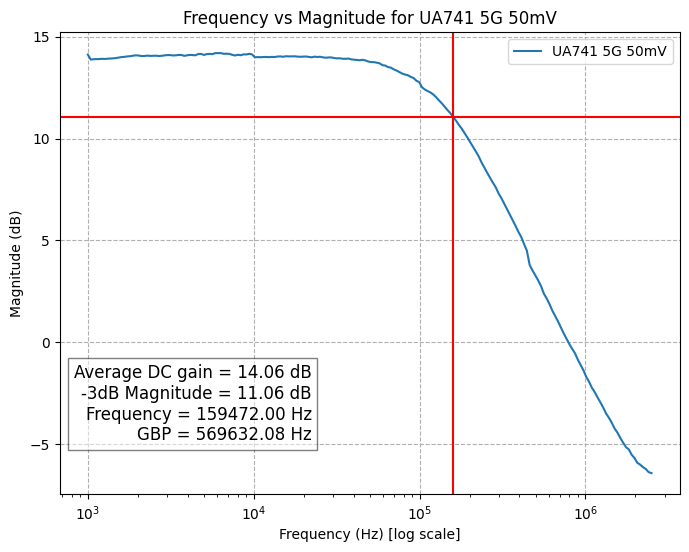

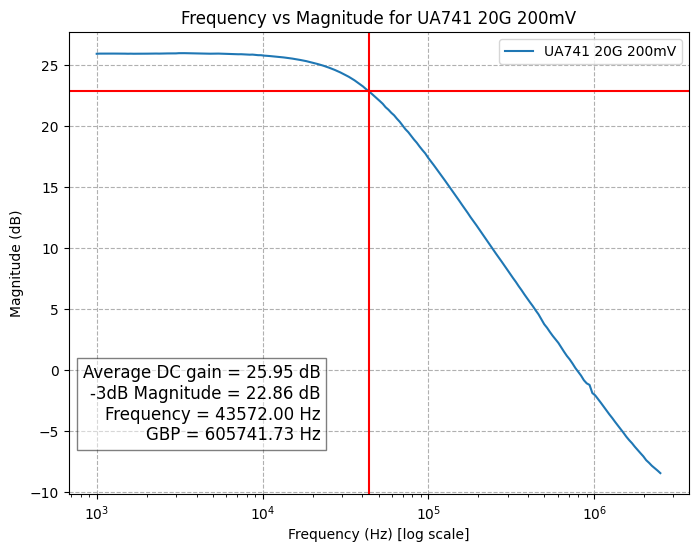

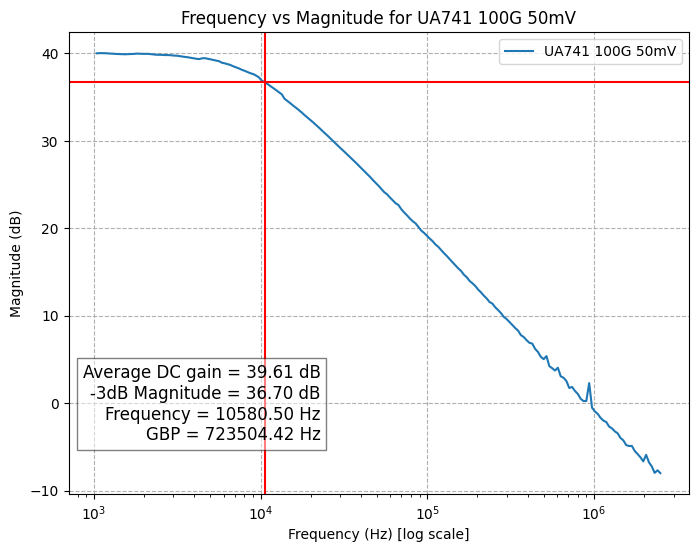

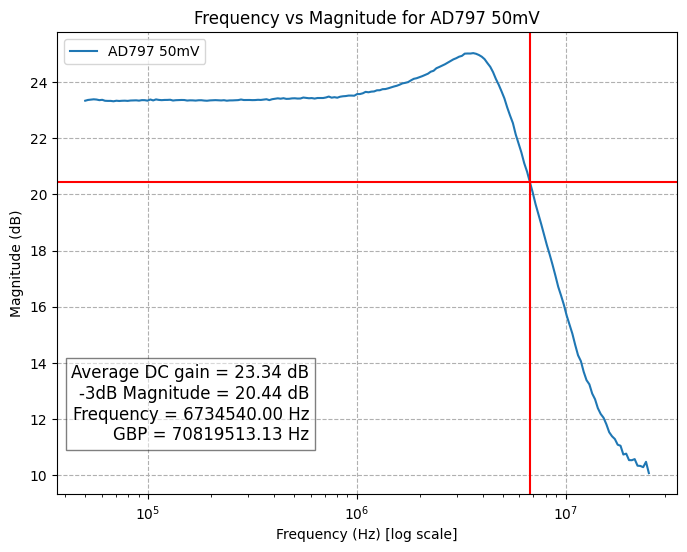

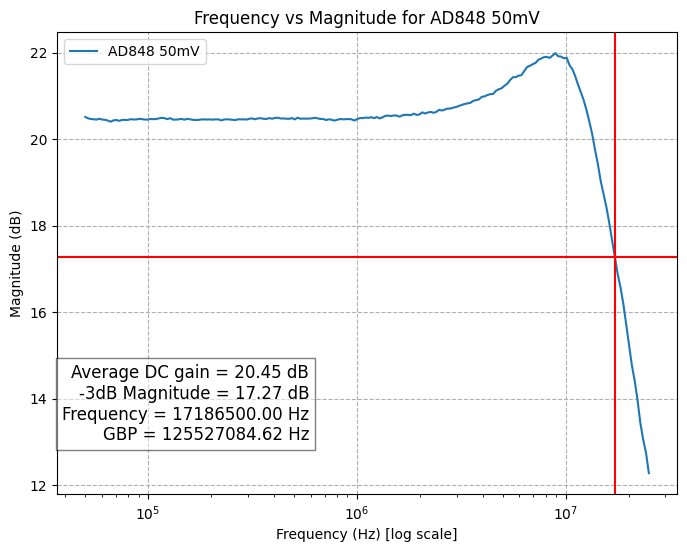

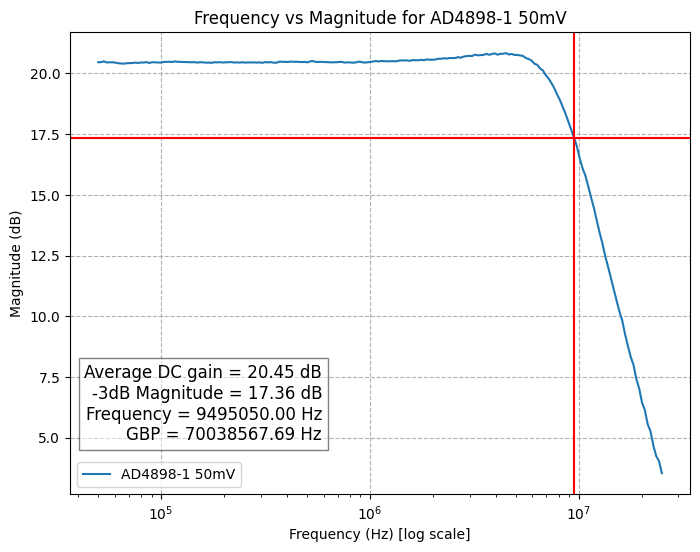

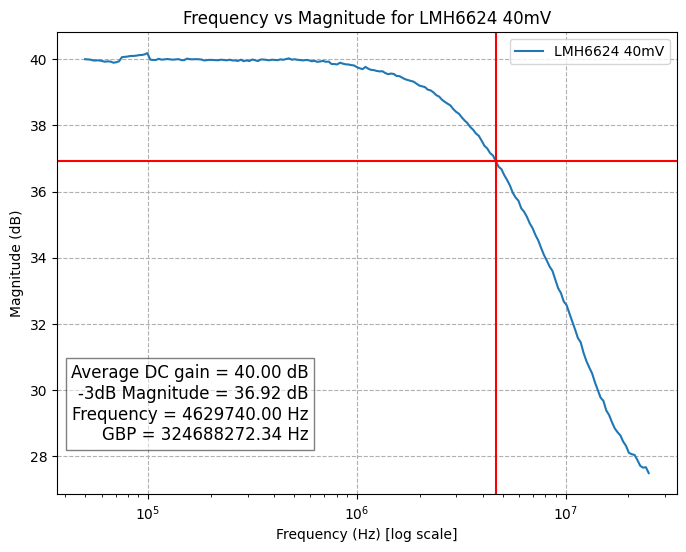

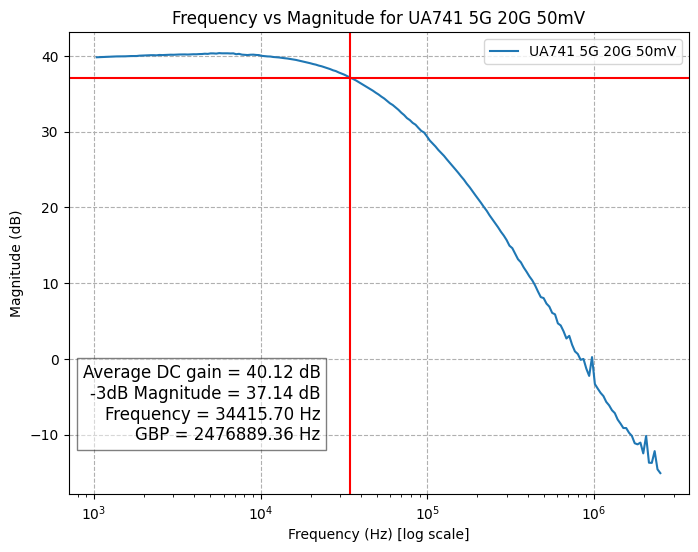

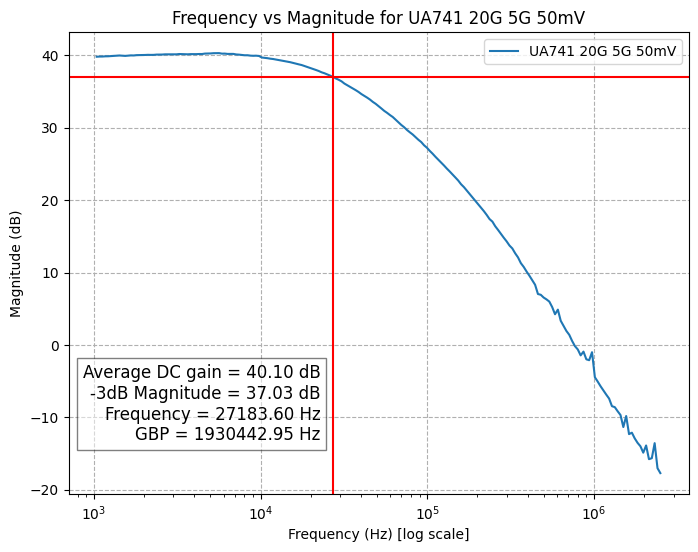

In [417]:
# Pick dataset
raw = False
#source_folder_to_plot = 'UA741_5Gain'  # Replace with folder name
#source_file_to_plot = 'UA741_5G_50mV'  # Replace with file name

# Call the plot functions for the specific folder and file
#plot_frequency_vs_magnitude(combined_df, source_folder_to_plot, source_file_to_plot, raw)
#plot_frequency_vs_phase(combined_df, source_folder_to_plot, source_file_to_plot, raw)
#plot_frequency_vs_magnitude_phase(combined_df, source_folder_to_plot, source_file_to_plot, raw)

source_folder_to_plot = 'UA741_5Gain'  # Replace with folder name
source_file_to_plot = 'UA741_5G_20mV'  # Replace with file name
#plot_frequency_vs_magnitude(combined_df, source_folder_to_plot, source_file_to_plot, raw)

source_folder_to_plot = 'UA741_5Gain'  # Replace with folder name
source_file_to_plot = 'UA741_5G_50mV'  # Replace with file name
plot_frequency_vs_magnitude(combined_df, source_folder_to_plot, source_file_to_plot, raw)

source_folder_to_plot = 'UA741_5Gain'  # Replace with folder name
source_file_to_plot = 'UA741_5G_100mV'  # Replace with file name
#plot_frequency_vs_magnitude(combined_df, source_folder_to_plot, source_file_to_plot, raw)

source_folder_to_plot = 'UA741_5Gain'  # Replace with folder name
source_file_to_plot = 'UA741_5G_1000mV'  # Replace with file name
#plot_frequency_vs_magnitude(combined_df, source_folder_to_plot, source_file_to_plot, raw)

source_folder_to_plot = 'UA741_5Gain'  # Replace with folder name
source_file_to_plot = 'UA741_5G_1400mV'  # Replace with file name
#plot_frequency_vs_magnitude(combined_df, source_folder_to_plot, source_file_to_plot, raw)

source_folder_to_plot = 'UA741_20Gain'  # Replace with folder name
source_file_to_plot = 'UA741_20G_200mV'  # Replace with file name
plot_frequency_vs_magnitude(combined_df, source_folder_to_plot, source_file_to_plot, raw)

source_folder_to_plot = 'UA741_100Gain'  # Replace with folder name
source_file_to_plot = 'UA741_100G_50mV'  # Replace with file name
plot_frequency_vs_magnitude(combined_df, source_folder_to_plot, source_file_to_plot, raw)

source_folder_to_plot = 'AD797'  # Replace with folder name
source_file_to_plot = 'AD797_50mV'  # Replace with file name
plot_frequency_vs_magnitude(combined_df, source_folder_to_plot, source_file_to_plot, raw)

source_folder_to_plot = 'AD848'  # Replace with folder name
source_file_to_plot = 'AD848_50mV'  # Replace with file name
plot_frequency_vs_magnitude(combined_df, source_folder_to_plot, source_file_to_plot, raw)

source_folder_to_plot = 'AD4898-1'  # Replace with folder name
source_file_to_plot = 'AD4898-1_50mV'  # Replace with file name
plot_frequency_vs_magnitude(combined_df, source_folder_to_plot, source_file_to_plot, raw)

source_folder_to_plot = 'LMH6624'  # Replace with folder name
source_file_to_plot = 'LMH6624_40mV'  # Replace with file name
plot_frequency_vs_magnitude(combined_df, source_folder_to_plot, source_file_to_plot, raw)

source_folder_to_plot = 'UA741_5Gain_20Gain'  # Replace with folder name
source_file_to_plot = 'UA741_5G_20G_50mV'  # Replace with file name
plot_frequency_vs_magnitude(combined_df, source_folder_to_plot, source_file_to_plot, raw)

source_folder_to_plot = 'UA741_20Gain_5Gain'  # Replace with folder name
source_file_to_plot = 'UA741_20G_5G_50mV'  # Replace with file name
plot_frequency_vs_magnitude(combined_df, source_folder_to_plot, source_file_to_plot, raw)


In [418]:
# Plot Frequency (Hz) vs Magnitude (dB) for all files in a folder
def plot_all_files_magnitude(df, source_folder, raw):
    # Filter by EB folder
    folder_data = df[df['source_folder'] == source_folder]
    files_in_folder = folder_data['source_file'].unique()
    folder_label = folder_data['source_folder_label'].iloc[0]

    plt.figure(figsize=(8, 6))
    
    # Loop through each file and plot its data
    print('label\tcutoff_frequency\tmagnitude\tlinear_magnitude\tgbp')
    for source_file in files_in_folder:
        plot_data = select_data(df, source_folder, source_file, raw)
        plot_label = plot_data['source_file_label'].iloc[0]
        avg_dc_gain, frequency, magnitude = find_cutoff(plot_data, 50)
        linear_magnitude = 10**(magnitude / 20.0)
        gbp = frequency * linear_magnitude
        print(f'{plot_label}\t{frequency:.0f}\t{magnitude:.2f}\t{linear_magnitude:.2f}\t{gbp:.0f}')
#        print(f'{plot_label}\t{gbp3:.0f}')
        plt.plot(plot_data['Frequency(Hz)'], plot_data['Magnitude(dB)'], label=plot_label)
    
    plt.xscale('log')
    plt.xlabel('Frequency (Hz) [log scale]')
    plt.ylabel('Magnitude (dB)')
    plt.title(f'Frequency vs Magnitude for {folder_label}')
    plt.grid(True, which="major", ls="--")
    plt.legend()

#    plt.savefig(f'C:\\Users\\david\\Desktop\\Quantum\\PHYS4680\\Analog1\\Analog_Lab\\GraphsForTeamReport\\FrequencyVsMagnitudeFor{source_folder}.png', bbox_inches='tight')
    plt.show()

In [419]:
# Plot Frequency (Hz) vs Phase (°) for all files in a folder
def plot_all_files_phase(df, source_folder, raw):
    # Filter by EB folder
    folder_data = df[df['source_folder'] == source_folder]
    files_in_folder = folder_data['source_file'].unique()
    
    plt.figure(figsize=(8, 6))

    # Loop through each file and plot its data
    for source_file in files_in_folder:
        plot_data = select_data(df, source_folder, source_file, raw)
        plot_label = plot_data['source_file_label'].iloc[0]
        plt.plot(plot_data['Frequency(Hz)'], plot_data['Phase(°)'], label=plot_label)
    
    plt.xscale('log')
    plt.xlabel('Frequency (Hz) [log scale]')
    plt.ylabel('Phase (degree)')
    plt.title(f'Frequency vs Phase for {source_folder}')
    plt.grid(True, which="major", ls="--")
    plt.legend()
    plt.show()

label	cutoff_frequency	magnitude	linear_magnitude	gbp
UA741 5G 20mV	186632	10.10	3.20	597106
UA741 5G 50mV	159472	11.06	3.57	569632
UA741 5G 100mV	153324	11.01	3.55	544710
UA741 5G 1000mV	81735	10.83	3.48	284471
UA741 5G 1400mV	62070	11.01	3.55	220502


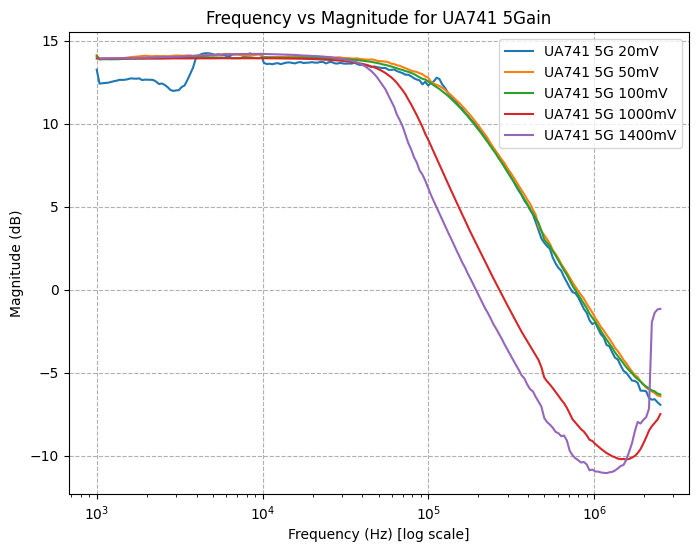

label	cutoff_frequency	magnitude	linear_magnitude	gbp
UA741 20G 20mV	53037	22.01	12.61	668809
UA741 20G 50mV	47136	23.03	14.17	668132
UA741 20G 100mV	45319	22.94	14.03	635868
UA741 20G 200mV	43572	22.86	13.90	605742


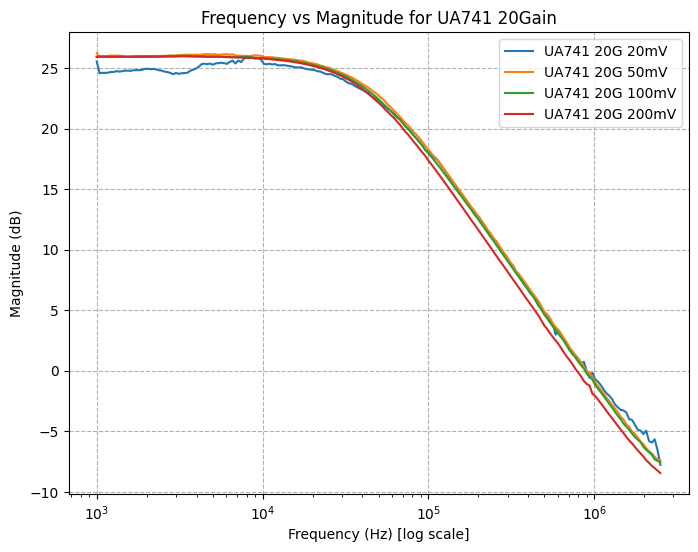

label	cutoff_frequency	magnitude	linear_magnitude	gbp
UA741 100G 20mV	11446	35.63	60.46	692028
UA741 100G 40mV	11005	36.21	64.62	711080
UA741 100G 50mV	10580	36.70	68.38	723504
UA741 100G 60mV	10580	36.51	66.89	707695


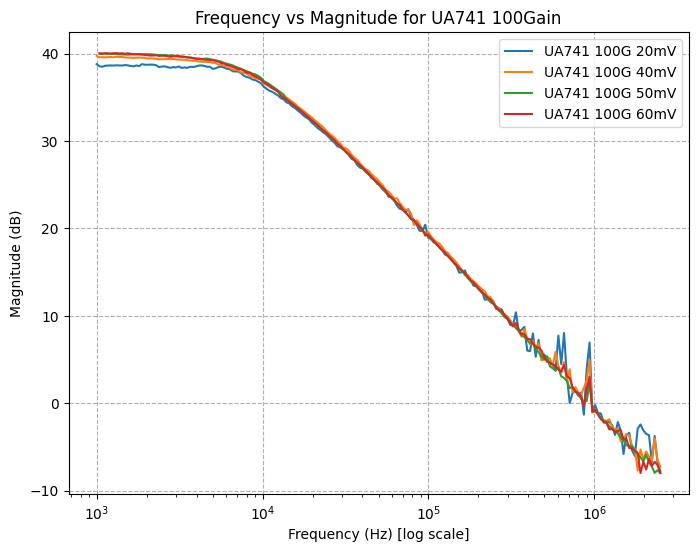

label	cutoff_frequency	magnitude	linear_magnitude	gbp
AD797 20mV	7395990	20.03	10.03	74205538
AD797 40mV	6948180	20.51	10.60	73667522
AD797 50mV	6734540	20.44	10.52	70819513
AD797 100mV	4776600	20.47	10.56	50445087
AD797 200mV	2809010	20.35	10.41	29238379


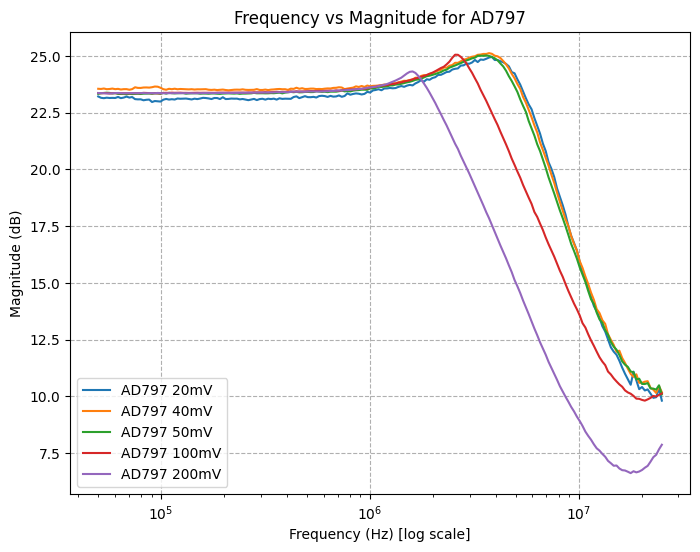

label	cutoff_frequency	magnitude	linear_magnitude	gbp
AD848 20mV	16658100	17.23	7.27	121124073
AD848 40mV	16658100	17.69	7.67	127732221
AD848 50mV	17186500	17.27	7.30	125527085
AD848 100mV	16658100	17.49	7.49	124833304
AD848 200mV	16658100	17.35	7.37	122765253


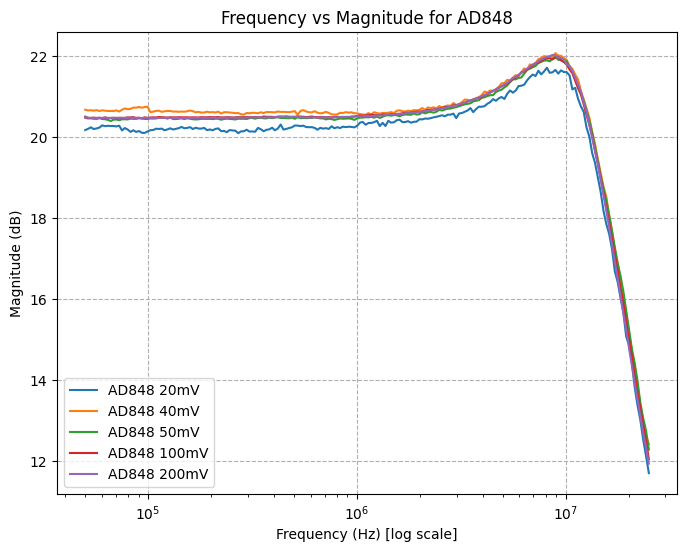

label	cutoff_frequency	magnitude	linear_magnitude	gbp
AD4898-1 20mV	9495050	17.04	7.11	67499764
AD4898-1 40mV	9203110	17.77	7.73	71173711
AD4898-1 50mV	9495050	17.36	7.38	70038568
AD4898-1 100mV	9203110	17.35	7.37	67832779
AD4898-1 200mV	7630600	17.46	7.47	56974259


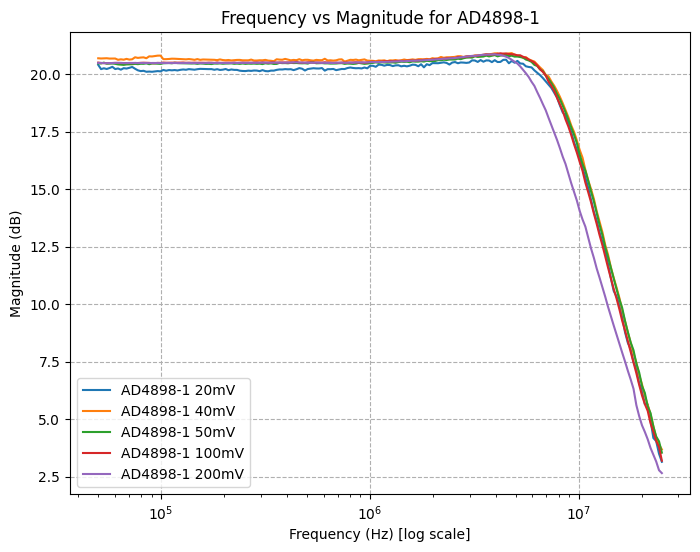

label	cutoff_frequency	magnitude	linear_magnitude	gbp
LMH6624 20mV	4629740	36.57	67.41	312102036
LMH6624 40mV	4629740	36.92	70.13	324688272


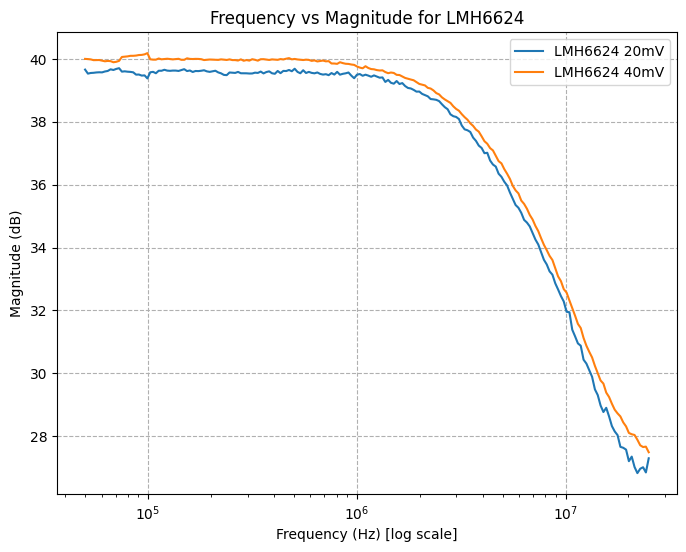

label	cutoff_frequency	magnitude	linear_magnitude	gbp
UA741 5G 20G 20mV	38724	35.75	61.28	2373190
UA741 5G 20G 40mV	35796	36.81	69.27	2479631
UA741 5G 20G 50mV	34416	37.14	71.97	2476889
UA741 5G 20G 60mV	33089	37.26	72.95	2413889


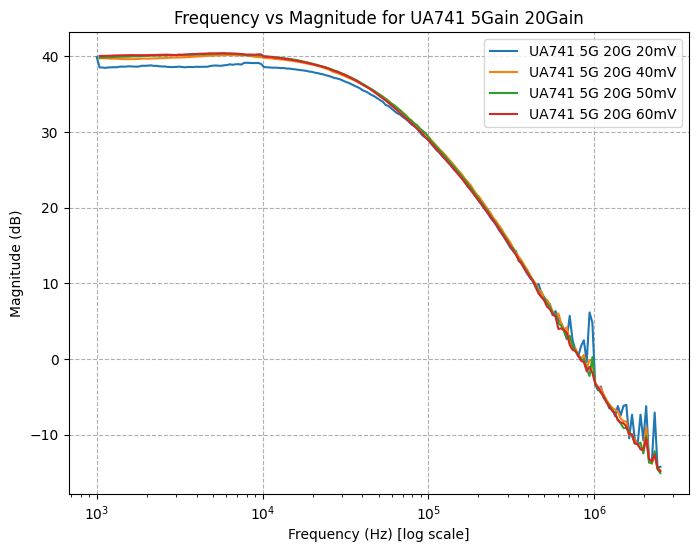

label	cutoff_frequency	magnitude	linear_magnitude	gbp
UA741 20G 5G 20mV	29407	35.74	61.23	1800494
UA741 20G 5G 40mV	27184	36.88	69.86	1898965
UA741 20G 5G 50mV	27184	37.03	71.01	1930443
UA741 20G 5G 60mV	25128	37.24	72.75	1828147


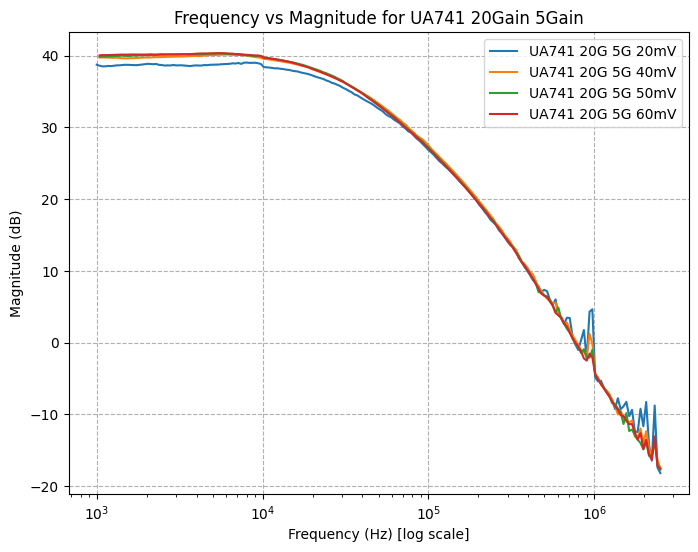

In [420]:
# Pick folder of EB's to plot
raw = False
source_folder_to_plot = 'UA741_5Gain'  # Replace with desired folder name
plot_all_files_magnitude(combined_df, source_folder_to_plot, raw)
#plot_all_files_phase(combined_df, source_folder_to_plot, raw)

source_folder_to_plot = 'UA741_20Gain'  # Replace with desired folder name
plot_all_files_magnitude(combined_df, source_folder_to_plot, raw)
#plot_all_files_phase(combined_df, source_folder_to_plot, raw)

source_folder_to_plot = 'UA741_100Gain'  # Replace with desired folder name
plot_all_files_magnitude(combined_df, source_folder_to_plot, raw)
#plot_all_files_phase(combined_df, source_folder_to_plot, raw)

source_folder_to_plot = 'AD797'  # Replace with desired folder name
plot_all_files_magnitude(combined_df, source_folder_to_plot, raw)
#plot_all_files_phase(combined_df, source_folder_to_plot, raw)

source_folder_to_plot = 'AD848'  # Replace with desired folder name
plot_all_files_magnitude(combined_df, source_folder_to_plot, raw)
#plot_all_files_phase(combined_df, source_folder_to_plot, raw)

source_folder_to_plot = 'AD4898-1'  # Replace with desired folder name
plot_all_files_magnitude(combined_df, source_folder_to_plot, raw)
#plot_all_files_phase(combined_df, source_folder_to_plot, raw)

source_folder_to_plot = 'LMH6624'  # Replace with desired folder name
plot_all_files_magnitude(combined_df, source_folder_to_plot, raw)
#plot_all_files_phase(combined_df, source_folder_to_plot, raw)

source_folder_to_plot = 'UA741_5Gain_20Gain'  # Replace with desired folder name
plot_all_files_magnitude(combined_df, source_folder_to_plot, raw)
#plot_all_files_phase(combined_df, source_folder_to_plot, raw)

source_folder_to_plot = 'UA741_20Gain_5Gain'  # Replace with desired folder name
plot_all_files_magnitude(combined_df, source_folder_to_plot, raw)
#plot_all_files_phase(combined_df, source_folder_to_plot, raw)

In [421]:
class FolderFile:
    def __init__(self, source_folder, source_file):
        self.source_folder = source_folder
        self.source_file = source_file

In [422]:
# Plot Frequency (Hz) vs Magnitude (dB) for selected files
def plot_file_magnitudes(df, folder_files, raw):
    plt.figure(figsize=(8, 6))
    
    # Loop through each file and plot its data
    for folder_file in folder_files:
        plot_data = select_data(df, folder_file.source_folder, folder_file.source_file, raw)
        plot_label = plot_data['source_file_label'].iloc[0]
        plt.plot(plot_data['Frequency(Hz)'], plot_data['Magnitude(dB)'], label=plot_label)
    
    plt.xscale('log')
    plt.xlabel('Frequency (Hz) [log scale]')
    plt.ylabel('Magnitude (dB)')
    plt.title(f'Frequency vs Magnitude for selected op-amps')
    plt.grid(True, which="major", ls="--")
    plt.legend()
    plt.show()

In [423]:
# Plot Frequency (Hz) vs Magnitude (dB)
def plot_frequency_vs_magnitude(df, source_folder, source_file, raw):
    plot_data = select_data(df, source_folder, source_file, raw)
    
    plt.figure(figsize=(8, 6))
    
    plt.plot(plot_data['Frequency(Hz)'], plot_data['Magnitude(dB)'], label=f'{source_file}')
    
    plt.xscale('log')
    plt.xlabel('Frequency (Hz) [log scale]')
    plt.ylabel('Magnitude (dB)')
    plt.title(f'Frequency vs Magnitude for {source_file}')
    plt.grid(True, which="major", ls="--")
    plt.legend()
    plt.show()

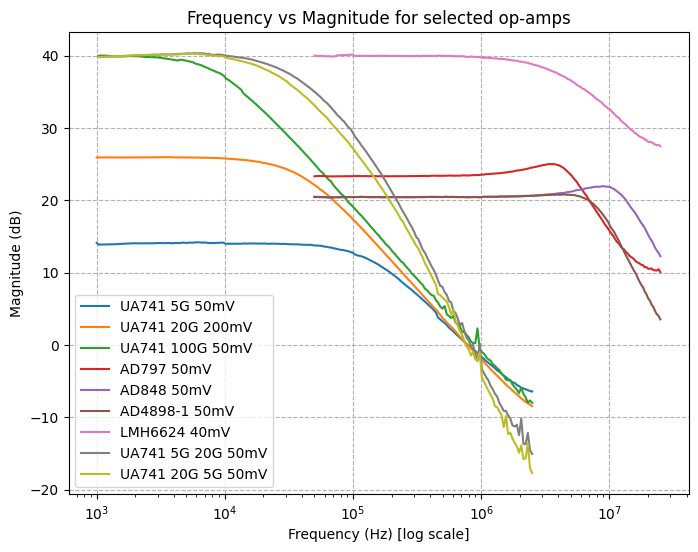

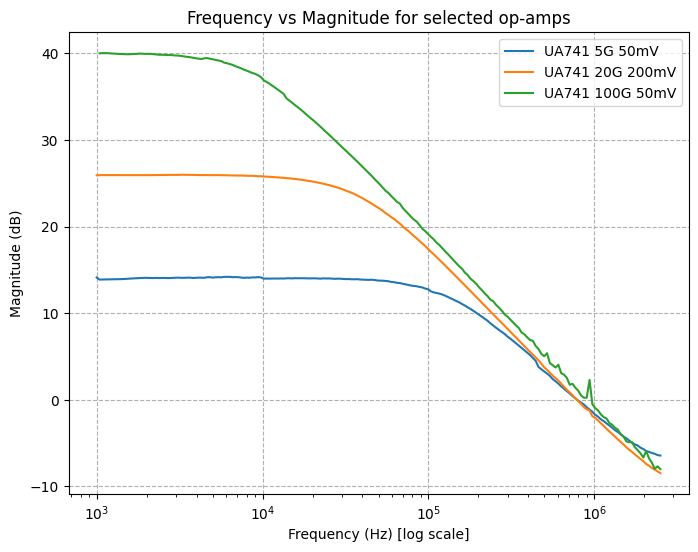

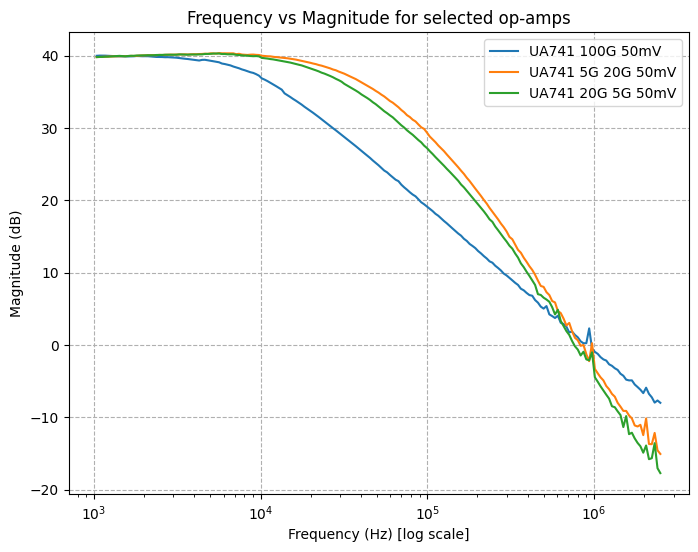

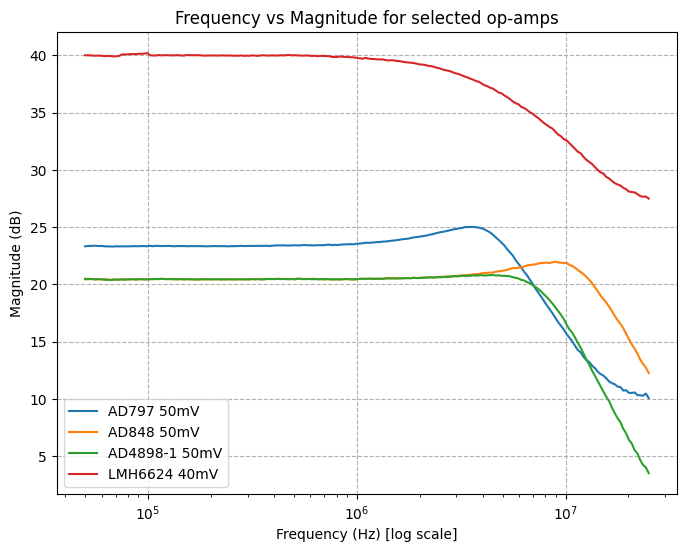

In [424]:
# Pick specific EB's and Inputs to plot
raw = False

plot_file_magnitudes(combined_df, [
    FolderFile('UA741_5Gain', 'UA741_5G_50mV'),
    FolderFile('UA741_20Gain','UA741_20G_200mV'), 
    FolderFile('UA741_100Gain','UA741_100G_50mV'),
    FolderFile('AD797','AD797_50mV'),
    FolderFile('AD848','AD848_50mV'),
    FolderFile('AD4898-1','AD4898-1_50mV'),
    FolderFile('LMH6624','LMH6624_40mV'),
    FolderFile('UA741_5Gain_20Gain','UA741_5G_20G_50mV'), 
    FolderFile('UA741_20Gain_5Gain','UA741_20G_5G_50mV')
], raw)

plot_file_magnitudes(combined_df, [
    FolderFile('UA741_5Gain', 'UA741_5G_50mV'),
    FolderFile('UA741_20Gain','UA741_20G_200mV'), 
    FolderFile('UA741_100Gain','UA741_100G_50mV'),
#    FolderFile('UA741_5Gain_20Gain','UA741_5G_20G_50mV'), 
#    FolderFile('UA741_20Gain_5Gain','UA741_20G_5G_50mV')
], raw)

plot_file_magnitudes(combined_df, [
    FolderFile('UA741_100Gain','UA741_100G_50mV'),
    FolderFile('UA741_5Gain_20Gain','UA741_5G_20G_50mV'), 
    FolderFile('UA741_20Gain_5Gain','UA741_20G_5G_50mV')
], raw)

plot_file_magnitudes(combined_df, [
    FolderFile('AD797','AD797_50mV'),
    FolderFile('AD848','AD848_50mV'),
    FolderFile('AD4898-1','AD4898-1_50mV'),
    FolderFile('LMH6624','LMH6624_40mV'),
], raw)

In [425]:
def model_func(w, wa, a):
    return a / (1 + (-1**.5)(w/wa))

wa = 4629740

<>:2: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<>:2: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
C:\Users\david\AppData\Local\Temp\ipykernel_11204\3180325834.py:2: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
  return a / (1 + (-1**.5)(w/wa))


In [426]:
# Plot Frequency (Hz) vs Linear Magnitude
def plot_frequency_vs_linear_magnitude(df, source_folder, source_file, raw):
    plot_data = select_data(df, source_folder, source_file, raw)
    plot_label = plot_data['source_file_label'].iloc[0]
#    avg_dc_gain, frequency, magnitude = find_cutoff(plot_data, 50)

    plt.figure(figsize=(8, 6))
    
#    plt.plot(plot_data['Frequency(Hz)'], plot_data['Magnitude(dB)'], label=f'{source_file}')
    plt.plot(plot_data['Frequency(Hz)'], plot_data['Linear Magnitude'], label=plot_label)

#    plt.axvline(x=frequency, color='r')
#    plt.axhline(y=magnitude, color='r')

    plt.xscale('log')
    plt.xlabel('Frequency (Hz) [log scale]')
    plt.ylabel('Linear Magnitude')
    plt.title(f'Frequency vs Magnitude for {plot_label}')
    plt.grid(True, which="major", ls="--")
    plt.legend()
#    plt.figtext(0.44, 0.2, f'Average DC gain = {avg_dc_gain:.2f} dB\n-3dB Magnitude = {magnitude:.2f} dB\nFrequency = {frequency:.2f} Hz', horizontalalignment='right', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

#    plt.savefig(f'C:\\Users\\david\\Desktop\\Quantum\\PHYS4680\\Analog1\\Analog_Lab\\GraphsForTeamReport\\CutoffFrequencyFor{source_file}.png', bbox_inches='tight')
    plt.show()

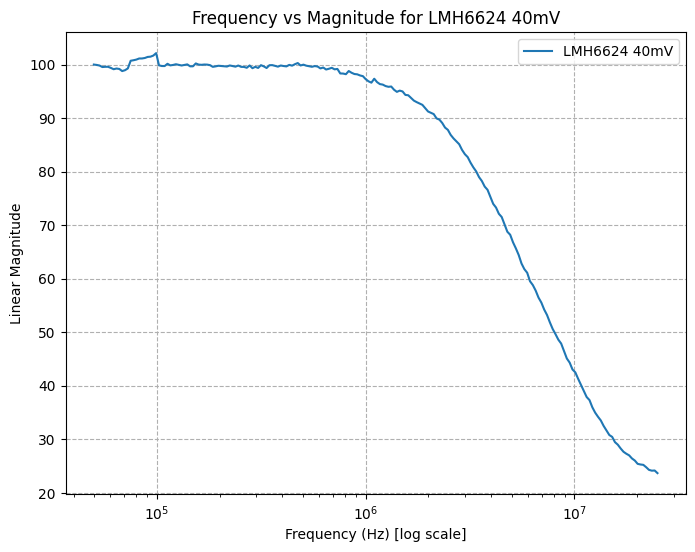

In [427]:
raw = False

source_folder_to_plot = 'LMH6624'  # Replace with folder name
source_file_to_plot = 'LMH6624_40mV'  # Replace with file name
plot_frequency_vs_linear_magnitude(combined_df, source_folder_to_plot, source_file_to_plot, raw)
